In [1]:
import h5py
import numpy as np
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import torch.optim as optim
import torch
import torch.nn as nn
from d2l import torch as d2l

label = ['singlepulse', 'freqdiv', 'LFM', 'QFM', '2FSK', '4FSK', 'BPSK', 'QPSK']

In [2]:
class ModulationDataSets(Dataset):
    __lazy: bool = False
    __PSK:bool = True
    def __init__(self, file, lazy=False):
        self.__lazy = lazy
        self.h5 = h5py.File(file, "r")
        self.label_id = torch.tensor(self.h5['sampleType'][:], dtype=torch.long)
        self.length = 0
        _, self.length = self.label_id.shape
        # if self.__PSK:
        #     self.label_id[self.label_id==8]=7

        self.toTenser= ToTensor()
        if not lazy:
            self.img = self.toTenser(self.h5['sampleData'][:]).float().reshape(-1,1,196,64)
        else:
            self.img = self.h5['sampleData']

    def __getitem__(self, idx):
        img = self.img[idx,:,:] if not self.__lazy else self.toTenser(self.img[:, :, idx]).float()
        return img,self.label_id[0,idx]-1
    def __len__(self):
        return self.length

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.h5.close()

In [3]:
train_path = r'E:\train.h5'
test_path = r'E:\test.h5'
train_dataset = ModulationDataSets(train_path)
test_dataset = ModulationDataSets(test_path)

In [5]:
x,_=test_dataset.__getitem__(1)
x.shape

torch.Size([1, 196, 64])

In [4]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=0, drop_last=False)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True,
    num_workers=0, drop_last=False)

In [7]:
i = iter(train_loader)
img,label= next(i)
img:torch.Tensor=img
img.shape

torch.Size([64, 1, 196, 64])

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(1196000, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 1196000)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


net = Net()

In [9]:
from collections import OrderedDict

net = nn.Sequential(OrderedDict([
    ('conv1', nn.Conv2d(1, 10, kernel_size=(3, 3),padding=1)), ('pool1', nn.MaxPool2d(2)), ('ReLU1', nn.ReLU()),
    ('conv2', nn.Conv2d(10, 20, kernel_size=(3, 3),padding=1)), ('pool2', nn.MaxPool2d(2)), ('ReLU2', nn.ReLU()),
    ('conv3', nn.Conv2d(20, 40, kernel_size=(3, 3), padding=1)),
    ('drop3', nn.Dropout2d()),
    ('pool3', nn.MaxPool2d(2)), ('ReLU3', nn.ReLU()),
    ('flatten', nn.Flatten()),
    ('linear1', nn.Linear(7680, 4096)), ('linearReLU1', nn.ReLU()),
    ('linear2', nn.Linear(4096, 50)),('linearReLU2', nn.ReLU()),
    ('linear3', nn.Linear(50, 7)),
    ('output', nn.Softmax())
]))

In [5]:
net = nn.Sequential(
    nn.Conv2d(1,10,kernel_size=5),nn.MaxPool2d(2),nn.ReLU(),
    nn.Conv2d(10,20,kernel_size=5),nn.Dropout2d(0.2),nn.MaxPool2d(2),nn.ReLU(),
    nn.Flatten(),
    nn.Linear(11960,4096),nn.ReLU(),
    nn.Linear(4096,50),nn.ReLU(),
    nn.Dropout(0),
    nn.Linear(50,8),
    nn.Softmax()
)

In [6]:
net.load_state_dict(torch.load('basic-8.parm'))

<All keys matched successfully>

In [5]:
X = torch.rand(size=(1, 1, 196, 64), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "output shape: \t", X.shape)

Conv2d output shape: 	 torch.Size([1, 10, 192, 60])
MaxPool2d output shape: 	 torch.Size([1, 10, 96, 30])
ReLU output shape: 	 torch.Size([1, 10, 96, 30])
Conv2d output shape: 	 torch.Size([1, 20, 92, 26])
Dropout2d output shape: 	 torch.Size([1, 20, 92, 26])
MaxPool2d output shape: 	 torch.Size([1, 20, 46, 13])
ReLU output shape: 	 torch.Size([1, 20, 46, 13])
Flatten output shape: 	 torch.Size([1, 11960])
Linear output shape: 	 torch.Size([1, 4096])
ReLU output shape: 	 torch.Size([1, 4096])
Linear output shape: 	 torch.Size([1, 50])
ReLU output shape: 	 torch.Size([1, 50])
Dropout output shape: 	 torch.Size([1, 50])
Linear output shape: 	 torch.Size([1, 8])
Softmax output shape: 	 torch.Size([1, 8])


C:\Users\ZGYwi\AppData\Local\Temp\ipykernel_23432\3752330140.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  X = layer(X)


In [7]:
def train_ch6(net, loss, train_iter, test_iter, num_epochs, lr, lambd, device):
    """Train a model with a GPU (defined in Chapter 6). """

    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.5,
                                weight_decay=lambd)

    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
def init_weights(net: nn.Module):
    def init(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init)

In [11]:
init_weights(net)

In [12]:
loss= nn.CrossEntropyLoss()

loss 1.448, train acc 0.825, test acc 0.815
1544.3 examples/sec on cuda:0


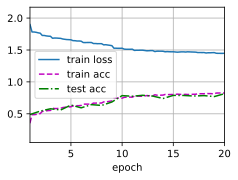

In [13]:
n_epochs = 20
train_ch6(net, loss, train_loader, test_loader, n_epochs, 0.1, 0, d2l.try_gpu())

loss 1.365, train acc 0.911, test acc 0.870
1521.8 examples/sec on cuda:0


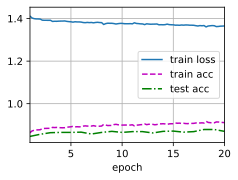

In [14]:
n_epochs =20
train_ch6(net, loss, train_loader, test_loader, n_epochs, 0.01, 0, d2l. v())

In [10]:
torch.save(net.state_dict(),"basic-8.parm")